# Appling machine learning to audio analysis

## Trainning Code - Using cut audios of setA. No moving windows.

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/660a715714d5400799df5c31f750ed94



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [6]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    audio = shannonEnergy(audio)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    mfccs_out = mfccs_processed
     
    return mfccs_out

In [7]:
# Shannon energy envelope method
def shannonEnergy(audio):
    audioShannon = []
    maxAudio = np.ndarray.max(audio)

    for i in audio:
        if i < 10**(-5):
            audioShannon.append(0)

        else:
            i = i/maxAudio
            energyS = -(i**2)*np.log10(i**2)
            audioShannon.append(energyS)

    audioPlot = np.array(audioShannon)
    meanShannon = np.mean(audioPlot)
    stdShannon = np.std(audioPlot)

    Power = []
    for i in audioPlot:
        Power.append((i - meanShannon)/stdShannon)

    powerPlot = np.array(audioShannon)
    return powerPlot

In [8]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [9]:
from os.path import exists

In [10]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 # Counts how many files had their MFCCs analised
i = 0 # total number of files

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    #print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            sounds.append([data, class_label])
            cont += 1
        else:
            # if the file is empty, it will print its name
            print(file_name)
            
print(i, cont)

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1750
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1751
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1222
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1122
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1888
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224

801 800


In [11]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain_shannon_mfccs40.pkl') 

## Model building and training

### Load MFFCs from saved files

In [12]:
fileMFCCs = '../MFCCs/cutA_toTrain_shannon_mfccs40.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [13]:
keras.backend.clear_session()
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [15]:
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (640, 512)                20992     
_________________________________________________________________
activation (Activation)      (640, 512)                0         
_________________________________________________________________
dropout (Dropout)            (640, 512)                0         
_________________________________________________________________
dense_1 (Dense)              (640, 512)                262656    
_________________________________________________________________
activation_1 (Activation)    (640, 512)                0         
_________________________________________________________________
dropout_1 (Dropout)          (640, 512)                0         
_________________________________________________________________
dense_2 (Dense)              (640, 512)                2

### Model Trainning

In [16]:
num_epochs = 700
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/700
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9c44c19818> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9c44c19818> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


20/20 [==============================] - 6s 7ms/step - loss: 18.8044 - accuracy: 0.3781 - val_loss: 2.3928 - val_accuracy: 0.5375
Epoch 2/700
20/20 [==============================] - 0s 5ms/step - loss: 9.3746 - accuracy: 0.3969 - val_loss: 1.5755 - val_accuracy: 0.5375
Epoch 3/700
20/20 [==============================] - 0s 4ms/step - loss: 6.1930 - accuracy: 0.4297 - val_loss: 0.9802 - val_accuracy: 0.5312
Epoch 4/700
20/20 [==============================] - 0s 4ms/step - loss: 3.9424 - accuracy: 0.4234 - val_loss: 0.9529 - val_accuracy: 0.5188
Epoch 5/700
20/20 [==============================] - 0s 4ms/step - loss: 3.1321 - accuracy: 0.3844 - val_loss: 0.9168 - val_accuracy: 0.5625
Epoch 6/700
20/20 [==============================] - 0s 4ms/step - loss: 2.3096 - accuracy: 0.4641 - val_loss: 0.9214 - val_accuracy: 0.6187
Epoch 7/700
20/20 [==============================] - 0s 4ms/step - loss: 2.0517 - accuracy: 0.4406 - val_loss: 0.9386 - val_accuracy: 0.6313
Epoch 8/700
20/20 [=====

Epoch 59/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.6562 - val_loss: 0.6363 - val_accuracy: 0.6687
Epoch 60/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6562 - val_loss: 0.6164 - val_accuracy: 0.7625
Epoch 61/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.6453 - val_loss: 0.6187 - val_accuracy: 0.7250
Epoch 62/700
20/20 [==============================] - 0s 7ms/step - loss: 0.6786 - accuracy: 0.6594 - val_loss: 0.6013 - val_accuracy: 0.7375
Epoch 63/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6906 - val_loss: 0.5893 - val_accuracy: 0.7688
Epoch 64/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6875 - val_loss: 0.5709 - val_accuracy: 0.7688
Epoch 65/700
20/20 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6750 - val_loss: 0.5728 - val_accuracy: 0.7875
Epoch 

20/20 [==============================] - 0s 5ms/step - loss: 0.3990 - accuracy: 0.8125 - val_loss: 0.4347 - val_accuracy: 0.8375
Epoch 117/700
20/20 [==============================] - 0s 4ms/step - loss: 0.4278 - accuracy: 0.8031 - val_loss: 0.4163 - val_accuracy: 0.8250
Epoch 118/700
20/20 [==============================] - 0s 4ms/step - loss: 0.3919 - accuracy: 0.8297 - val_loss: 0.4352 - val_accuracy: 0.8375
Epoch 119/700
20/20 [==============================] - 0s 4ms/step - loss: 0.3550 - accuracy: 0.8391 - val_loss: 0.4398 - val_accuracy: 0.8313
Epoch 120/700
20/20 [==============================] - 0s 4ms/step - loss: 0.4126 - accuracy: 0.8234 - val_loss: 0.4860 - val_accuracy: 0.8313
Epoch 121/700
20/20 [==============================] - 0s 4ms/step - loss: 0.3750 - accuracy: 0.8234 - val_loss: 0.4387 - val_accuracy: 0.8313
Epoch 122/700
20/20 [==============================] - 0s 4ms/step - loss: 0.3688 - accuracy: 0.8375 - val_loss: 0.4686 - val_accuracy: 0.8250
Epoch 123/700

20/20 [==============================] - 0s 4ms/step - loss: 0.2675 - accuracy: 0.8938 - val_loss: 0.4938 - val_accuracy: 0.8313
Epoch 174/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2795 - accuracy: 0.8719 - val_loss: 0.5278 - val_accuracy: 0.8125
Epoch 175/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2826 - accuracy: 0.8813 - val_loss: 0.6450 - val_accuracy: 0.8062
Epoch 176/700
20/20 [==============================] - 0s 7ms/step - loss: 0.2645 - accuracy: 0.8969 - val_loss: 0.4798 - val_accuracy: 0.8438
Epoch 177/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2998 - accuracy: 0.8656 - val_loss: 0.5188 - val_accuracy: 0.8375
Epoch 178/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2506 - accuracy: 0.8922 - val_loss: 0.5453 - val_accuracy: 0.8438
Epoch 179/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2858 - accuracy: 0.8828 - val_loss: 0.4874 - val_accuracy: 0.8250
Epoch 180/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1994 - accuracy: 0.9047 - val_loss: 0.6358 - val_accuracy: 0.8250
Epoch 231/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9047 - val_loss: 0.6707 - val_accuracy: 0.8500
Epoch 232/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.9094 - val_loss: 0.7964 - val_accuracy: 0.8125
Epoch 233/700
20/20 [==============================] - 0s 5ms/step - loss: 0.2348 - accuracy: 0.8938 - val_loss: 0.6876 - val_accuracy: 0.8250
Epoch 234/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9312 - val_loss: 0.6224 - val_accuracy: 0.8562
Epoch 235/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.9156 - val_loss: 0.7479 - val_accuracy: 0.8313
Epoch 236/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1574 - accuracy: 0.9391 - val_loss: 0.6602 - val_accuracy: 0.8562
Epoch 237/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9234 - val_loss: 0.8198 - val_accuracy: 0.8625
Epoch 288/700
20/20 [==============================] - 0s 4ms/step - loss: 0.2020 - accuracy: 0.9266 - val_loss: 0.7847 - val_accuracy: 0.8562
Epoch 289/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1555 - accuracy: 0.9406 - val_loss: 0.8071 - val_accuracy: 0.8375
Epoch 290/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1536 - accuracy: 0.9297 - val_loss: 0.7794 - val_accuracy: 0.8375
Epoch 291/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.9484 - val_loss: 0.7706 - val_accuracy: 0.8500
Epoch 292/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9469 - val_loss: 0.7941 - val_accuracy: 0.8500
Epoch 293/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1455 - accuracy: 0.9422 - val_loss: 0.8224 - val_accuracy: 0.8375
Epoch 294/700

20/20 [==============================] - 0s 5ms/step - loss: 0.1494 - accuracy: 0.9391 - val_loss: 0.7454 - val_accuracy: 0.8438
Epoch 345/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1177 - accuracy: 0.9641 - val_loss: 0.8889 - val_accuracy: 0.8500
Epoch 346/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.9656 - val_loss: 0.8757 - val_accuracy: 0.8562
Epoch 347/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1390 - accuracy: 0.9469 - val_loss: 0.7587 - val_accuracy: 0.8375
Epoch 348/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9703 - val_loss: 0.7647 - val_accuracy: 0.8625
Epoch 349/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.9531 - val_loss: 0.9047 - val_accuracy: 0.8438
Epoch 350/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1148 - accuracy: 0.9609 - val_loss: 1.0198 - val_accuracy: 0.8500
Epoch 351/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1527 - accuracy: 0.9484 - val_loss: 0.8872 - val_accuracy: 0.8438
Epoch 402/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9516 - val_loss: 1.0391 - val_accuracy: 0.8375
Epoch 403/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9453 - val_loss: 0.9443 - val_accuracy: 0.8500
Epoch 404/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.9500 - val_loss: 0.9519 - val_accuracy: 0.8438
Epoch 405/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9422 - val_loss: 0.8742 - val_accuracy: 0.8438
Epoch 406/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1149 - accuracy: 0.9531 - val_loss: 0.8876 - val_accuracy: 0.8687
Epoch 407/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9641 - val_loss: 1.0387 - val_accuracy: 0.8687
Epoch 408/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1279 - accuracy: 0.9547 - val_loss: 1.1107 - val_accuracy: 0.8313
Epoch 459/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9469 - val_loss: 0.9901 - val_accuracy: 0.8250
Epoch 460/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9766 - val_loss: 0.9842 - val_accuracy: 0.8250
Epoch 461/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9578 - val_loss: 0.7982 - val_accuracy: 0.8687
Epoch 462/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9563 - val_loss: 0.9455 - val_accuracy: 0.8313
Epoch 463/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0847 - accuracy: 0.9688 - val_loss: 1.0257 - val_accuracy: 0.8313
Epoch 464/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1260 - accuracy: 0.9547 - val_loss: 1.0037 - val_accuracy: 0.8375
Epoch 465/700

20/20 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 0.9703 - val_loss: 1.1305 - val_accuracy: 0.8500
Epoch 516/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0847 - accuracy: 0.9766 - val_loss: 1.0515 - val_accuracy: 0.8562
Epoch 517/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9688 - val_loss: 0.9856 - val_accuracy: 0.8562
Epoch 518/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1130 - accuracy: 0.9688 - val_loss: 0.9289 - val_accuracy: 0.8625
Epoch 519/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9500 - val_loss: 0.9541 - val_accuracy: 0.8500
Epoch 520/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9609 - val_loss: 1.1964 - val_accuracy: 0.8375
Epoch 521/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0982 - accuracy: 0.9625 - val_loss: 0.9707 - val_accuracy: 0.8562
Epoch 522/700

20/20 [==============================] - 0s 4ms/step - loss: 0.0781 - accuracy: 0.9703 - val_loss: 0.8283 - val_accuracy: 0.8375
Epoch 573/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9781 - val_loss: 0.9951 - val_accuracy: 0.8313
Epoch 574/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1115 - accuracy: 0.9672 - val_loss: 0.9656 - val_accuracy: 0.8438
Epoch 575/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0970 - accuracy: 0.9703 - val_loss: 0.9365 - val_accuracy: 0.8313
Epoch 576/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1349 - accuracy: 0.9609 - val_loss: 0.8616 - val_accuracy: 0.8438
Epoch 577/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9688 - val_loss: 0.9043 - val_accuracy: 0.8313
Epoch 578/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0846 - accuracy: 0.9688 - val_loss: 1.0089 - val_accuracy: 0.8250
Epoch 579/700

20/20 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9766 - val_loss: 0.9720 - val_accuracy: 0.8813
Epoch 630/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0992 - accuracy: 0.9656 - val_loss: 1.1381 - val_accuracy: 0.8313
Epoch 631/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1063 - accuracy: 0.9750 - val_loss: 1.1599 - val_accuracy: 0.8813
Epoch 632/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1136 - accuracy: 0.9563 - val_loss: 1.1406 - val_accuracy: 0.8438
Epoch 633/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9516 - val_loss: 0.8608 - val_accuracy: 0.8500
Epoch 634/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1408 - accuracy: 0.9453 - val_loss: 0.8890 - val_accuracy: 0.8313
Epoch 635/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9578 - val_loss: 0.9134 - val_accuracy: 0.8562
Epoch 636/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1164 - accuracy: 0.9656 - val_loss: 1.2698 - val_accuracy: 0.8375
Epoch 687/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1535 - accuracy: 0.9625 - val_loss: 1.0887 - val_accuracy: 0.8313
Epoch 688/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1177 - accuracy: 0.9484 - val_loss: 0.9046 - val_accuracy: 0.8625
Epoch 689/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9516 - val_loss: 0.8746 - val_accuracy: 0.8438
Epoch 690/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9641 - val_loss: 1.1225 - val_accuracy: 0.8562
Epoch 691/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1362 - accuracy: 0.9547 - val_loss: 0.7989 - val_accuracy: 0.8562
Epoch 692/700
20/20 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9719 - val_loss: 0.9143 - val_accuracy: 0.8625
Epoch 693/700

In [17]:
model.save('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700/saved_model', save_format='tf')

INFO:tensorflow:Assets written to: ../model_save/cut_setA_Train_shannon_mffcs40_Hist_700/saved_model/assets


### Confusion Matrix

In [18]:
predictions = model.predict(x_test)
y_classes = predictions.argmax(axis=-1) # Classes predicted
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [19]:
# makes the % of each element
total = []
for row in matrix:
    sum = 0
    for element in row:
        sum += element
    total.append(sum)
print(total)
matrix = matrix*100
for i in range(len(matrix)):
    matrix[i] = matrix[i]/total[i]

[44, 30, 86]


<Figure size 576x576 with 0 Axes>

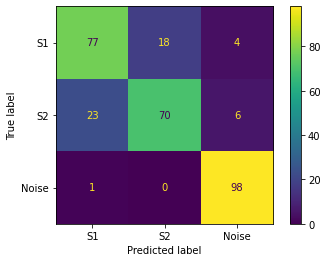

In [20]:
# Display confusion matrix with respective labels
fig = plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = ['S1','S2','Noise'])
disp.plot()
plt.show()

In [21]:
disp.figure_.savefig('../images/confusionMatrix/700Epoch_shannon_mfccs40.jpg')

### Plot of model performance

In [22]:
history = pd.read_csv('../model_save/cut_setA_Train_shannon_mffcs40_Hist_700.log')
history.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.378125,18.804377,0.53750,2.392760
1,1,0.396875,9.374567,0.53750,1.575520
2,2,0.429688,6.193046,0.53125,0.980163
3,3,0.423438,3.942396,0.51875,0.952853
4,4,0.384375,3.132147,0.56250,0.916762


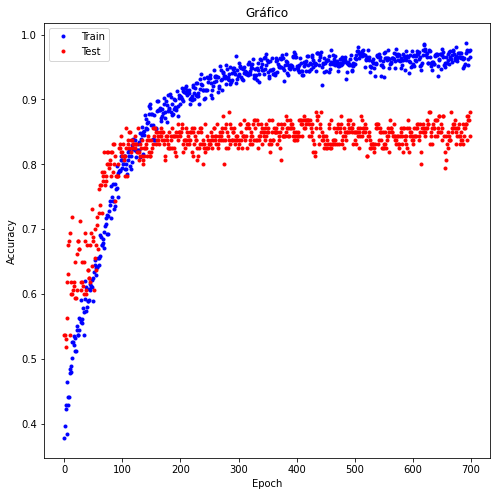

In [23]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)
# Plots the accuracy x epoch for train
Plot.plot(xx, yy, "b.", label = 'Train')

yy = np.array(history.val_accuracy.tolist())
# Plots the accuracy x epoch for test
Plot.plot(xx, yy, "r.", label = 'Test')

Plot.title.set_text("Gráfico")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")
Plot.legend()

In [24]:
fig.savefig('../images/performance/700Epoch_shannon_mfccs40.jpg')

In [25]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/660a715714d5400799df5c31f750ed94
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [700]                : (0.37812501192092896, 0.987500011920929)
COMET INFO:     batch_accuracy [1400]         : (0.28125, 1.0)
COMET INFO:     batch_loss [1400]             : (0.0010334029793739319, 25.489246368408203)
COMET INFO:     epoch_duration [700]          : (0.07796679999955813, 6.195861099999092)
COMET INFO:     loss [700]                    : (0.046965718269348145, 18.80437660217285)
COMET INFO:     val_accuracy [700]            : (0.518750011920929, 0.8812500238418579)
COMET INFO:     val_loss [700]                : (0.4128649830818176, 2.3927595615386963)
COMET INFO:     validate_batch_accuracy [700] : (0.4375, 0.84375